Your Goal: Predict the price of backpacks given various attributes.

Evaluation
Root Mean Squared Error (RMSE)
Submissions are scored on the root mean squared error. RMSE is defined as:

RMSE=(1N∑i=1N(yi−yˆi)2)12

where yˆi
 is the predicted value and yi
 is the original value for each instance i
.

Submission File
For each id in the test set, you must predict the Price of the backpack. The file should contain a header and have the following format:

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
train_df=pd.read_csv('train.csv')
test_df= pd.read_csv('test.csv')

Data exploration

In [48]:
train_df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [4]:
train_df.describe()

,id,Compartments,Weight Capacity (kg),Price
count,300000.000000,300000.000000,299862.000000,300000.000000
mean,149999.500000,5.443590,18.029994,81.411107
std,86602.684716,2.890766,6.966914,39.039340
min,0.000000,1.000000,5.000000,15.000000
25%,74999.750000,3.000000,12.097867,47.384620
50%,149999.500000,5.000000,18.068614,80.956120
75%,224999.250000,8.000000,24.002375,115.018160
max,299999.000000,10.000000,30.000000,150.000000


In [5]:
train_df.shape

(300000, 11)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [7]:
train_df.isna().sum()

id                         0
Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

In [19]:
train_df.isnull().sum()

id                         0
Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

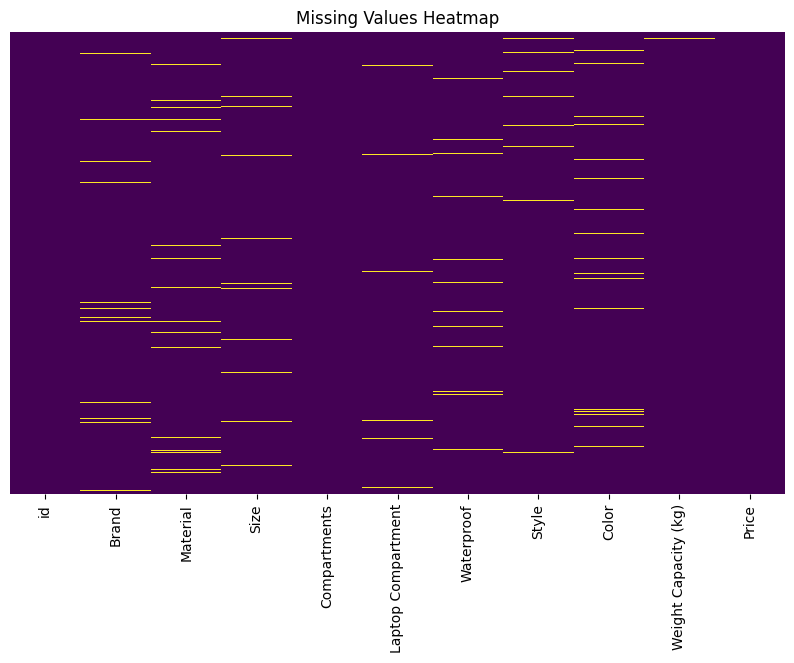

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

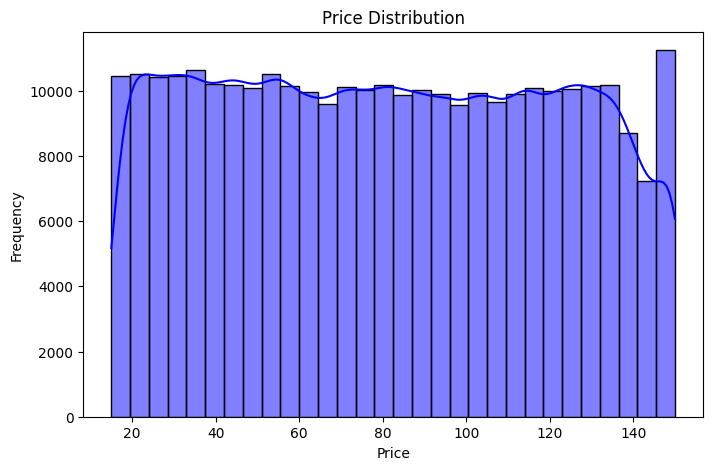

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df["Price"], bins=30, kde=True, color="blue")
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

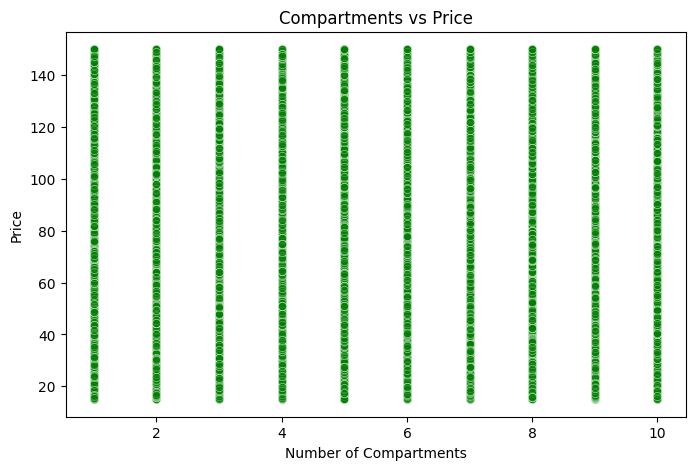

In [49]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=train_df["Compartments"], y=train_df["Price"], alpha=0.6, color="green")
plt.title("Compartments vs Price")
plt.xlabel("Number of Compartments")
plt.ylabel("Price")
plt.show()

C:\Users\Vidushi\AppData\Local\Temp\ipykernel_24732\1311968564.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_df["Brand"].value_counts().index[:10],


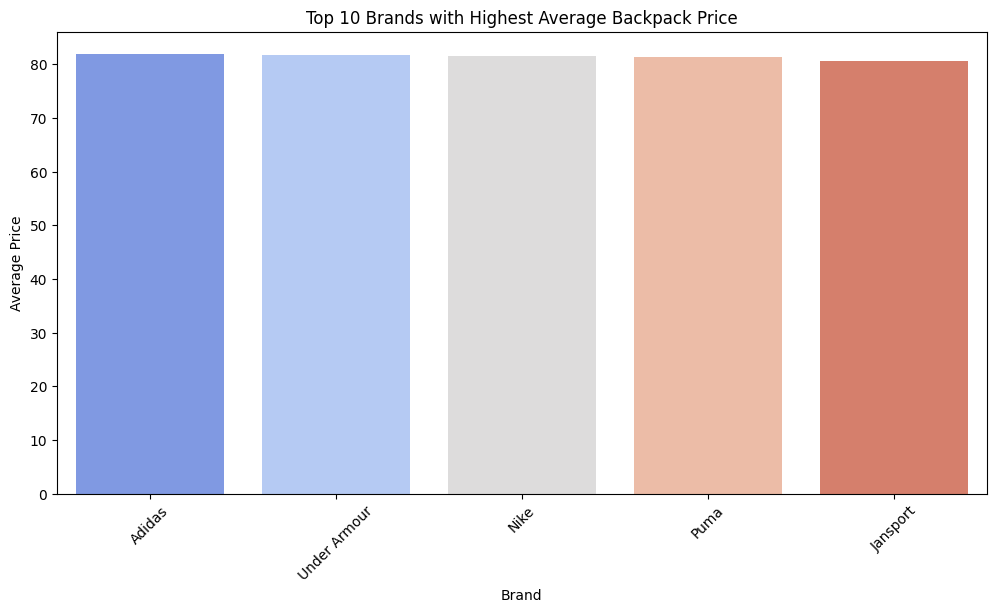

In [13]:
plt.figure(figsize=(12, 6))
sns.barplot(x=train_df["Brand"].value_counts().index[:10], 
            y=train_df.groupby("Brand")["Price"].mean().sort_values(ascending=False)[:10], 
            palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 10 Brands with Highest Average Backpack Price")
plt.xlabel("Brand")
plt.ylabel("Average Price")
plt.show()

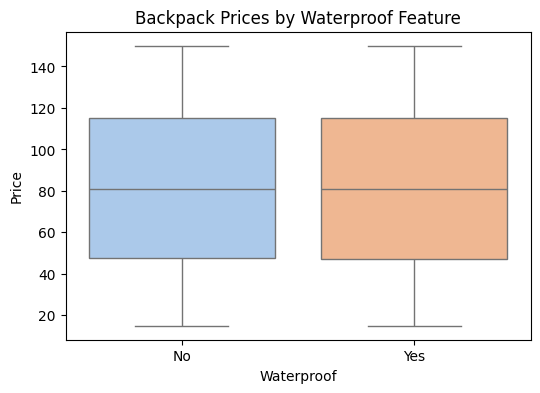

In [18]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="Waterproof", y="Price", data=train_df, hue="Waterproof", palette="pastel", legend=False)
plt.title("Backpack Prices by Waterproof Feature")
plt.xlabel("Waterproof")
plt.ylabel("Price")
plt.show()

Data preprocessing

In [20]:
train_df.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


def target_encode(train_df, test_df, cat_columns, target_column):
    encoding_dict = {}  # Store mappings
    
    for col in cat_columns:
        # Compute mean encoding from training data
        encoding = train_df.groupby(col)[target_column].mean()
        encoding_dict[col] = encoding  # Save encoding for test data
        
        # Apply encoding to training data
        train_df[col] = train_df[col].map(encoding)

    # Apply saved encoding to test data
    for col in cat_columns:
        test_df[col] = test_df[col].map(encoding_dict[col])

    return train_df, test_df  # Return both transformed DataFrames

cat_columns = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

train_df, test_df = target_encode(train_df, test_df, cat_columns, 'Price')

In [27]:
from sklearn.preprocessing import OneHotEncoder

cat_columns = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

encoder = OneHotEncoder(sparse_output=False, drop=None)

encoded_array = encoder.fit_transform(train_df[cat_columns])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_columns))

train_df = pd.concat([train_df.drop(columns=cat_columns), encoded_df], axis=1)

print(train_df)

            id  Compartments  Weight Capacity (kg)      Price  Brand_Adidas  \
0            0           7.0             11.611723  112.15875           0.0   
1            1          10.0             27.078537   68.88056           0.0   
2            2           2.0             16.643760   39.17320           0.0   
3            3           8.0             12.937220   80.60793           0.0   
4            4           1.0             17.749338   86.02312           1.0   
...        ...           ...                   ...        ...           ...   
299995  299995           9.0             12.730812  129.99749           1.0   
299996  299996           6.0             26.633182   19.85819           0.0   
299997  299997           9.0             11.898250  111.41364           0.0   
299998  299998           1.0              6.175738  115.89080           1.0   
299999  299999           2.0             18.568865   26.72762           0.0   

        Brand_Jansport  Brand_Nike  Brand_Puma  Bra

In [28]:
from sklearn.preprocessing import OneHotEncoder

cat_columns = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

encoder = OneHotEncoder(sparse_output=False, drop=None)  

encoded_array = encoder.fit_transform(test_df[cat_columns])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_columns))

test_df = pd.concat([test_df.drop(columns=cat_columns), encoded_df], axis=1)

print(test_df)


            id  Compartments  Weight Capacity (kg)  Brand_Adidas  \
0       300000           2.0             20.671147           0.0   
1       300001           7.0             13.564105           0.0   
2       300002           9.0             11.809799           1.0   
3       300003           1.0             18.477036           1.0   
4       300004           2.0              9.907953           1.0   
...        ...           ...                   ...           ...   
199995  499995           2.0              7.383498           1.0   
199996  499996           9.0              6.058394           0.0   
199997  499997           9.0             26.890163           0.0   
199998  499998          10.0             25.769153           0.0   
199999  499999           8.0             29.175026           0.0   

        Brand_Jansport  Brand_Nike  Brand_Puma  Brand_Under Armour  \
0                  0.0         0.0         1.0                 0.0   
1                  0.0         1.0         

In [22]:
train_df.isnull().sum()

id                          0
Compartments                0
Weight Capacity (kg)      138
Price                       0
Brand_Adidas                0
Brand_Jansport              0
Brand_Nike                  0
Brand_Puma                  0
Brand_Under Armour          0
Brand_nan                   0
Material_Canvas             0
Material_Leather            0
Material_Nylon              0
Material_Polyester          0
Material_nan                0
Size_Large                  0
Size_Medium                 0
Size_Small                  0
Size_nan                    0
Laptop Compartment_No       0
Laptop Compartment_Yes      0
Laptop Compartment_nan      0
Waterproof_No               0
Waterproof_Yes              0
Waterproof_nan              0
Style_Backpack              0
Style_Messenger             0
Style_Tote                  0
Style_nan                   0
Color_Black                 0
Color_Blue                  0
Color_Gray                  0
Color_Green                 0
Color_Pink

In [56]:
test_df.shape

(200000, 10)

In [25]:
train_df['Weight Capacity (kg)'] = train_df['Weight Capacity (kg)'].fillna(train_df['Weight Capacity (kg)'].mean()) 

categorical_columns = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

for col in categorical_columns:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

In [26]:
test_df['Weight Capacity (kg)'] = test_df['Weight Capacity (kg)'].fillna(test_df['Weight Capacity (kg)'].mean()) 

categorical_columns = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

for col in categorical_columns:
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

In [29]:
train_df.head()

,id,Compartments,Weight Capacity (kg),Price,Brand_Adidas,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Canvas,...,Waterproof_Yes,Style_Backpack,Style_Messenger,Style_Tote,Color_Black,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
0,0,7.0,11.611723,112.15875,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,10.0,27.078537,68.88056,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,2.0,16.643760,39.17320,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,8.0,12.937220,80.60793,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,1.0,17.749338,86.02312,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [30]:
test_df.head()

,id,Compartments,Weight Capacity (kg),Brand_Adidas,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Canvas,Material_Leather,...,Waterproof_Yes,Style_Backpack,Style_Messenger,Style_Tote,Color_Black,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
0,300000,2.0,20.671147,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,300001,7.0,13.564105,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,300002,9.0,11.809799,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,300003,1.0,18.477036,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,300004,2.0,9.907953,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [31]:
X= train_df.drop(columns=['Price'])
y= train_df.Price

In [32]:
X.shape

(300000, 28)

In [33]:
test_df.shape

(200000, 28)

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=42, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(10,)),  # Corrected input shape
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(
    n_estimators=150,       
    learning_rate=0.05,    
    max_depth=5,           
    subsample=0.8,         
    min_samples_split=4,   
    min_samples_leaf=2,    
    random_state=42
)

model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=2,
                          min_samples_split=4, n_estimators=150,
                          random_state=42, subsample=0.8)

In [36]:
pred=model.predict(X_test)

In [37]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

res= mean_absolute_error(pred, y_test)
res1= np.sqrt(mean_squared_error(pred, y_test))
print(res)
print(res1)

33.64407219325994
38.921006009776605


In [38]:
predictions= model.predict(test_df)

C:\Users\Vidushi\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


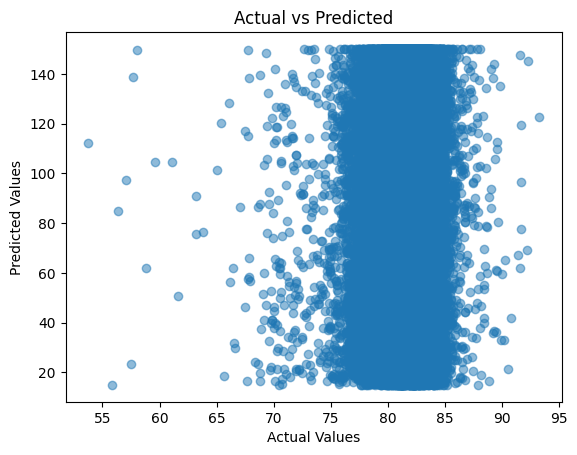

In [39]:
import matplotlib.pyplot as plt

plt.scatter(pred, y_test, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()


In [40]:
submission = pd.DataFrame({'id': test_df['id'], 'prediction': predictions})

submission.to_csv('submission1.csv', index=False)